# Métodos inciais - Reconhecimento Biométrico das Mãos

In [1]:
import numpy as np 
import pandas as pd
import imageio
import math
import cv2
import matplotlib.pyplot as plt

indexes = ['palm_length', 'palm_width', 'hand_length', 'hand_width', 'finger0_length', 'finger0_bot_width', 'finger0_mid_width', 'finger0_top_width', 'finger1_length', 'finger1_bot_width', 'finger1_mid_width', 'finger1_top_width', 'finger2_length', 'finger2_bot_width', 'finger2_mid_width', 'finger2_top_width', 'finger3_length', 'finger3_bot_width', 'finger3_mid_width', 'finger3_top_width', 'foto_id', 'person']

# Enable this for iteractive mode in Jupyter Notebook plots
# %matplotlib notebook

Carrega a imagem a ser reconhecida por biometria

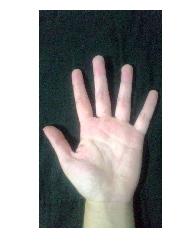

In [2]:
image = imageio.imread("handDatabase/person003_003.jpg")
plt.axis('off')
plt.imshow(image)
plt.show()

Implementa as funções para cálculo de variáveis utilizadas no algoritmo de Otsu

In [3]:
# Calculates a weigh for a class
def weigh(M, x1, x2, hist):
	return (1/M)*np.sum(hist[x1:x2])

# Calculates mean for a class
def mean(x1, x2, hist):

	a = 0 

	for i in range(x1, x2):
		a = a+(i*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

# Calculates variance for a class
def variance(x1, x2, mean, hist):

	a = 0

	for i in range(x1, x2):
		a = a+(math.pow(i-mean, 2)*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

Transformação da imagem RGB para escala de cinza

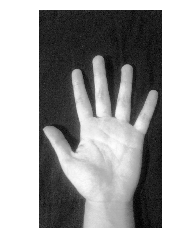

In [4]:
def grayTransform(img):
	return np.dot(img, [0.299, 0.587, 0.114])

gray = grayTransform(image).astype(int)

plt.axis('off')
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()

Implementação do algoritmo de Otsu, que detecta automaticamente o melhor thresholding a ser utilizado na imagem para conversão da imagem para binário

In [5]:
def otsuThresholding(img):

	# Computing histogram
	hist, bin_edges = np.histogram(img, bins='auto');
	# Converts array with edges to int
	bin_edges = bin_edges.astype(int)

	# New array to histogram
	histogram = np.zeros(255)

	# Fills new histogram
	for x in range(hist.size):
		histogram[bin_edges[x]] = hist[x]

	# Converts to int
	histogram = histogram.astype(int)

	intraclassVar = np.zeros(histogram.size)

	# Intra-class variance for each intensity
	for L in range(histogram.size):
		
		# Weigh for class A, sum of frequencies from 0 to L-1
		weighA = weigh(img.shape[0]*img.shape[1], 0, L, histogram)
		# Mean for class A
		meanA = mean(0, L+1, histogram)
		# Variance for class A
		varA = variance(0, L+1, meanA, histogram)

		# Weigh for class B, sum of frequencies from L to last item
		weighB = weigh(img.shape[0]*img.shape[1], L, histogram.size, histogram)
		# Mean for class B
		meanB = mean(L, histogram.size, histogram)
		# Variance for class B
		varB = variance(L, histogram.size, meanB, histogram)
		
		# Stores intraclass variance calculated
		intraclassVar[L] = weighA*varA + weighB*varB

		# Set the min value 
		if L is 0:
			minValue = intraclassVar[L]
		elif L != 0 and minValue > intraclassVar[L]: 
			minValue = intraclassVar[L] 

	# Returns the optimal thresholding
	return list(intraclassVar).index(minValue)

thresholding = otsuThresholding(gray)

Realiza a conversão da imagem para binário utilizando o thresholding obtido

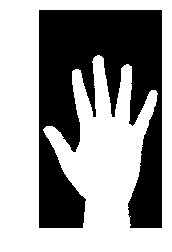

In [6]:
def binaryTransform(img, thresholding):

	binImg = np.zeros(img.shape)

	# Sets image values according to chosen thresholding
	for x in range(img.shape[0]):
		for y in range(img.shape[1]):
			if img[x,y] > thresholding: binImg[x,y] = 1

	return binImg

binImg = binaryTransform(gray, thresholding)

plt.axis('off')
plt.imshow(binImg, cmap='gray')
plt.show()

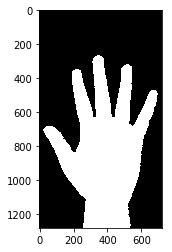

In [7]:
"""
Extracts the biggest object from a binary image with multiple objects
Parameters:
    binImg: binary image with multiple objects
Returns:
    mask: the binary mask with the biggest object
    contour: contour points of the biggest object
"""
def selectBiggestObject(binImg):

    binary = binImg.astype(np.uint8)

    # Reads the binary image
    img = image.astype(np.uint8)

    # Finding contours
    im2, contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Finding the biggest contour
    cnt = None
    cntArea = 0
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > cntArea:
            cnt = contours[i]
            cntArea = cv2.contourArea(contours[i])

    # Drawing the contour in the original image
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, (255), -1)
    
    return (mask, cnt)

mask, contour = selectBiggestObject(binImg)

plt.figure('Selected Object')
plt.imshow(mask, cmap='gray')

plt.show()

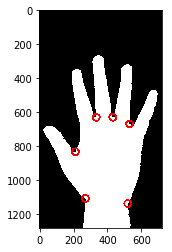

In [8]:
"""
Calculates the convex hull defects of a binary mask with one object
Parameters:
    contour: the contour points of the object in the mask
Returns:
    defects: the defects found in the convex hull of the object
"""
def convexHullDefects(contour):
    #generating convex hull and convexity defects
    hull = cv2.convexHull(contour, returnPoints = False)
    old_defects = cv2.convexityDefects(contour, hull)

    #iterating through defects and checking for defects that are too small
    defects = []
    for i in range(old_defects.shape[0]):
        s,e,f,d = old_defects[i,0]
        # if distance from defect to hull is smaller than 4000, continue
        if d < 4000:
            continue;
        # adding the big defects to a new array
        defects.append(old_defects[i])
        
    return np.array(defects)


defects = convexHullDefects(contour)

# Plotting results
test_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
for d in defects:
    start, end, far, distance = d[0]
    far_tuple = tuple(contour[far, 0])
    cv2.circle(test_img, far_tuple,20,(255,0,0), 10)

plt.figure('Defects found:')
plt.imshow(test_img)
plt.show()

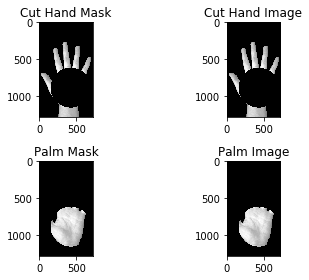

In [9]:
""" 
Cuts the palm from the binary mask of the hand
Parameters:
    mask: binary mask of the hand
    cnt: contour points of the binary mask
    defects: convex hull defects of the binary mask contour
Returns:
    cut_hand_mask: binary mask without the palm
    palm_mask: binary mask of the palm cut from mask
"""
def cutPalm(mask, cnt, defects):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Finding cut points
    points = []
    for i in range(defects.shape[0]):
        start = tuple( cnt[defects[i  ,0,2]][0] )
        points.append(start)
    
    # Adjusting the array for minEnclosingCircle
    # Needs to be an array of format (ROWSx1x2), where each row has a tuple with (1, (x,y) ), x and y coordinates of each point
    array = np.array(points)
    array = array.reshape((-1,1,2))
    
    # calculates the minimum enclosing circle of the hand
    (x,y),radius = cv2.minEnclosingCircle(array)
    center = (int(x),int(y))
    radius = int(radius)
    
    # Cutting hand from fingers_mask
    cut_hand_mask = np.copy(mask)
    cv2.circle(cut_hand_mask,center,radius,(0),-1)
    
    # Drawing palm_mask. Palm mask is an AND between the minEnclosingCircle and mask
    palm_mask = np.zeros_like(mask)
    cv2.circle(palm_mask,center,radius,(255),-1)
    palm_mask = cv2.bitwise_and(palm_mask, mask)
    
    return (cut_hand_mask, palm_mask)

cut_hand_mask, palm_mask = cutPalm(mask, contour, defects)


# Plots showing results
plt.figure('Results after cutting the hand mask')
plt.subplot(221)
plt.title('Cut Hand Mask')
plt.imshow(cut_hand_mask * gray, cmap='gray')
plt.subplot(222)
plt.title('Cut Hand Image')
plt.imshow(cut_hand_mask * gray, cmap='gray')

plt.subplot(223)
plt.title('Palm Mask')
plt.imshow(palm_mask * gray, cmap='gray')
plt.subplot(224)
plt.title('Palm Image')
plt.imshow(palm_mask * gray, cmap='gray')

plt.tight_layout()
plt.show()

In [10]:
"""
Removes the arm and the thumb from the cut_hand_mask
Parameters:
    cut_hand_mask: binary mask of the hand with the palm cut
Returns:
    five_fingers_mask: mask with all five fingers
    four_fingers_mask: mask with the four fingers and thumb removed
"""
def removeArmThumb(cut_hand_mask):
    
    # Finding contours
    im2, contours, hierarchy = cv2.findContours(cut_hand_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 10000]
    
    # Generates a Bounding Rectangle for each contour
    rects = [cv2.boundingRect(c) for c in contours]
    
    # Removes Contour with smallest with minimum Bouding Rectangle height (arm)
    min_h = float('inf')
    min_rect = -1
    for i in range(len(rects)):
        if(rects[i][3] < min_h):
            min_rect = i
            min_h = rects[i][3]
    rects.remove(rects[min_rect])
    contours.remove(contours[min_rect])
    
    # generates the five fingers mask
    five_fingers_mask = np.zeros_like(cut_hand_mask)
    for c in contours:
        cv2.drawContours(five_fingers_mask, [c], -1, (255) , -1)
            
    # Removes Contour with biggest Bounding Rectangle area (thumb)
    max_a = float('-inf')
    max_rect = -1
    for i in range(len(rects)):
        if((rects[i][3] * rects[i][2]) > max_a):
            max_rect = i
            max_a = (rects[i][3] * rects[i][2])
    rects.remove(rects[min_rect])
    contours.remove(contours[min_rect])
        
    # generates the four fingers mask
    four_fingers_mask = np.zeros_like(cut_hand_mask)
    for c in contours:
        cv2.drawContours(four_fingers_mask, [c], -1, (255), -1)
        
    return (four_fingers_mask, five_fingers_mask)
    
four_fingers_mask, five_fingers_mask = removeArmThumb(cut_hand_mask)

# Plotting stuff
plt.figure('Result:')
plt.subplot(1,2,1)
plt.imshow(four_fingers_mask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(five_fingers_mask, cmap='gray')

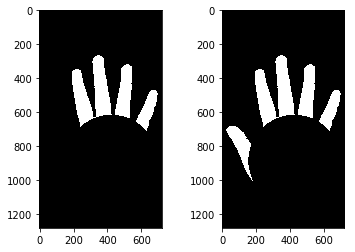

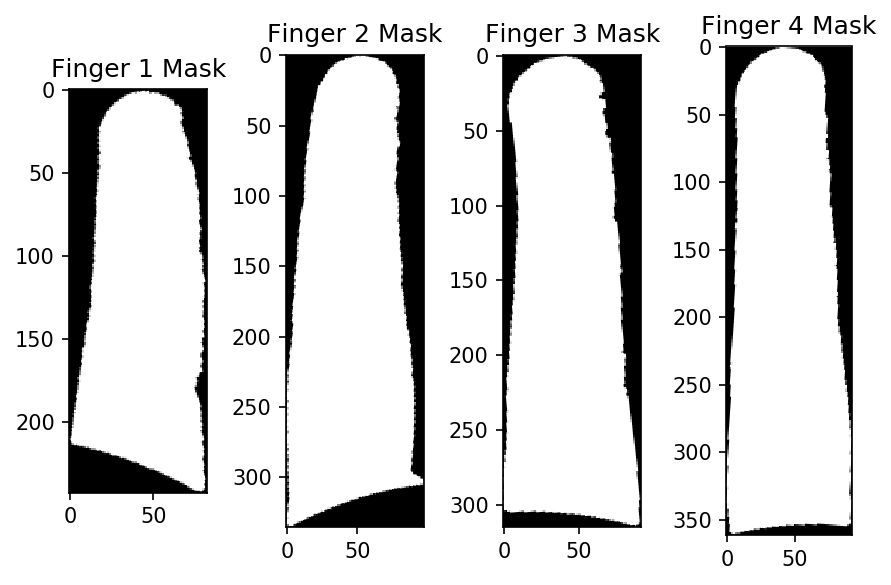

In [11]:
"""
Isolates each finger in the parameter mask into four binary masks,
cropped to the fingers minimum bounding rectangle and rotated so the finger faces up
Parameters:
    fingers_mask: mask with the four fingers that will be split intro separeted masks
Returns:
    fingers_masks: an array with 4 elements, each is an image with a finger binary mask
"""
def isolateFingers(fingers_mask):
    
    # Applying morphological opening for thin edges reduction
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    fingers_mask = cv2.morphologyEx(fingers_mask, cv2.MORPH_OPEN, kernel)
    
    #finding new contours after opening
    im2, contours, hierarchy = cv2.findContours(fingers_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Fingers_masks contains a binary mask of each finger
    fingers_masks = []
    
    for c, i in zip(contours, range(len(contours))):
        
        # Creating the new images
        fingers_masks.append(np.zeros_like(fingers_mask))
        
        # Drawing finger mask
        cv2.drawContours(fingers_masks[i], [c], -1, (255), -1) 
        
        # Generating rotated bounding rectangle
        rect = cv2.minAreaRect(c)
        
        # Changes rotation angle so fingers are always on horizontal.
        # This code might be wrong, need to check corner cases
        rot = rect[2] if rect[2] > -45 else rect[2] + 90 
        rotation_matrix = cv2.getRotationMatrix2D(rect[0], rot, 1.0)
        
        # Applies rotation to mask and image
        rotated_mask = cv2.warpAffine(fingers_masks[i], rotation_matrix, fingers_masks[i].shape[:2])
        
        # Finding new contour after rotation
        cont = cv2.findContours(rotated_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        # Getting new bouding rect
        x, y, w, h = cv2.boundingRect(cont[0])
        
        # Cropping finger mask
        fingers_masks[i] = np.zeros((w,h))
        fingers_masks[i] = rotated_mask[y:y+h , x:x+w]
        
    #returns a list containing each finger tuple(mask, image, contour)
    return fingers_masks
    
    

fingers_masks = isolateFingers(four_fingers_mask)

# Plotting results
plt.figure('Resultados: Dedos Isolados e suas Máscaras Binárias', dpi=150)
for finger, i in zip( fingers_masks, range(1, len(fingers_masks) + 1) ):
    plt.subplot(1,4,i)
    plt.title('Finger {0} Mask'.format(i))
    plt.imshow(finger, cmap='gray')
    
plt.tight_layout()
plt.show()

In [12]:
"""
Calculates the lenght and width of a finger mask
Parameters:
    finger mask: binary mask with a finger image
Returns:
    a tuple with height, width of bottom middle and top parts of the finger
"""
def fingerMeasure(finger_mask):
    
    # Finds the fingers contours
    im2, contours, hierarchy = cv2.findContours(finger_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Calculating the bounding box
    x, y, width, height = cv2.boundingRect(contours[0])
    
    # Bottom width is calculated at the 25% percentile of the height
    bot_width = np.count_nonzero(finger_mask[int(height * 0.25)])
    mid_width = np.count_nonzero(finger_mask[int(height * 0.50)])
    top_width = np.count_nonzero(finger_mask[int(height * 0.75)])
    
    return (height, bot_width, mid_width, top_width)

# Calculates fingers measures
fingers_measures = [fingerMeasure(f) for f in fingers_masks]
fingers_measures

[(243, 61, 69, 73), (336, 67, 78, 91), (315, 64, 73, 82), (362, 70, 77, 88)]

In [13]:
"""
Calculates the lenght and width of a object within a binary mask
Parameters:
    obj_mask: binary mask with the object
Returns:
    a tuple with he
"""
def objMeasure(obj_mask):

    # Finds the fingers contours
    im2, contours, hierarchy = cv2.findContours(obj_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Find biggest contour
    maxArea = -1
    maxC = None
    for c in contours:
        if(cv2.contourArea(c) > maxArea):
            maxC = c
            maxArea = cv2.contourArea(c)

    # Calculating the bounding box
    x, y, width, height = cv2.boundingRect(maxC)

    return (height, width)

# Calculates palm and hand measures
palm_measure = objMeasure(palm_mask)
hand_measure = objMeasure(palm_mask + five_fingers_mask)
print('Palm measures: {0}\nHand measures: {1}'.format(palm_measure,hand_measure))

Palm measures: (539, 476)
Hand measures: (887, 673)


In [14]:
"""
Generates a numpy array with the values from palm_measure, hand_measure and fingers_measures
Parameters:
    palm_measure: tuple with (heigth, width) of a palm
    hand_measure: tuple with (heigth, width) of a hand
    fingers_measures: list of tuples with (heigth, width_bottom, width_middle, width_top) of a finger
Returns:
    numpy array with values. The indexes are:
    'palm_length', 'palm_width', 'hand_length', 'hand_width', 'finger0_length',
    'finger0_bot_width', 'finger0_mid_width', 'finger0_top_width', 'finger1_length',
    'finger1_bot_width', 'finger1_mid_width', 'finger1_top_width', 'finger2_length',
    'finger2_bot_width', 'finger2_mid_width', 'finger2_top_width', 'finger3_length',
    'finger3_bot_width', 'finger3_mid_width', 'finger3_top_width'
"""

# Normalizes the values
def normalization(values, hand_length):
    
    normValues = []
    
    for v in values:
        normValues.append(v/hand_length)
    
    return normValues

def generateAttributesList(palm_measure, hand_measure, fingers_measures):
    values = [palm_measure[0], palm_measure[1], hand_measure[0], hand_measure[1]]
    hand_length = values[indexes.index('hand_length')]
    
    for finger in fingers_measures:
        values.append(finger[0])
        values.append(finger[1])
        values.append(finger[2])
        values.append(finger[3])
    return normalization(values, hand_length)

values = generateAttributesList(palm_measure, hand_measure, fingers_measures)

indexes = ['palm_length', 'palm_width', 'hand_length', 'hand_width', 'finger0_length', 'finger0_bot_width', 'finger0_mid_width', 'finger0_top_width', 'finger1_length', 'finger1_bot_width', 'finger1_mid_width', 'finger1_top_width', 'finger2_length', 'finger2_bot_width', 'finger2_mid_width', 'finger2_top_width', 'finger3_length', 'finger3_bot_width', 'finger3_mid_width', 'finger3_top_width']
pd.Series(values, indexes)

palm_length          0.607666
palm_width           0.536640
hand_length          1.000000
hand_width           0.758737
finger0_length       0.273957
finger0_bot_width    0.068771
finger0_mid_width    0.077790
finger0_top_width    0.082300
finger1_length       0.378805
finger1_bot_width    0.075536
finger1_mid_width    0.087937
finger1_top_width    0.102593
finger2_length       0.355130
finger2_bot_width    0.072153
finger2_mid_width    0.082300
finger2_top_width    0.092446
finger3_length       0.408117
finger3_bot_width    0.078918
finger3_mid_width    0.086809
finger3_top_width    0.099211
dtype: float64

In [15]:
"""
Does the whole processing described above for an image
Parameters:
    filename: image filename
Returns:
    an numpy array with all attributes extracted
"""
def processImage(filename, indexes):
        
    #generates name and 
    name = filename.split('/')[-1].split('_')[0]
    photo_id = int(filename.split('/')[-1].split('_')[1].replace('.jpg',''))
    
    # Opens image, turns image to grayscale
    gray = grayTransform(imageio.imread(filename)).astype(int)
    # Applies otsu threshold to create a binary mask for image
    binImg = binaryTransform(gray, otsuThresholding(gray))
    # generates a mask and a contour for the object in the binary image
    mask, contour = selectBiggestObject(binImg)
    # finds biggest defects in contour convex hull
    defects = convexHullDefects(contour)
    # separates the palm from the hand in the binary mask
    cut_hand_mask, palm_mask = cutPalm(mask, contour, defects)
    # separates the fingers from the cut hand mask
    four_fingers_mask, five_fingers_mask = removeArmThumb(cut_hand_mask)
    # separates each finger in a separate mask and rotates them so all fingers are pointing up
    fingers_masks = isolateFingers(four_fingers_mask)
    # calculates all measures for fingers
    fingers_measures = [fingerMeasure(f) for f in fingers_masks]
    # calculates all measures for palm
    palm_measure = objMeasure(palm_mask)
    # calculates all measures for hand
    hand_measure = objMeasure(palm_mask + five_fingers_mask)
    
    values = generateAttributesList(palm_measure, hand_measure, fingers_measures)
    indexes.append('photo_id')
    values.append(photo_id)
    indexes.append('name')
    values.append(name)

    #generates a numpy array with all measurements
    return np.array(values)

pd.Series(processImage('handDatabase/person002_001.jpg', indexes), index=indexes)

palm_length           0.6389177939646202
palm_width            0.5421436004162331
hand_length                          1.0
hand_width            0.8366285119667014
finger0_length        0.2601456815816857
finger0_bot_width    0.08012486992715921
finger0_mid_width    0.07492195629552549
finger0_top_width    0.08428720083246619
finger1_length        0.3631633714880333
finger1_bot_width    0.07388137356919876
finger1_mid_width    0.08324661810613944
finger1_top_width    0.09469302809573361
finger2_length       0.31633714880332986
finger2_bot_width    0.07804370447450572
finger2_mid_width    0.08012486992715921
finger2_top_width    0.08636836628511967
finger3_length        0.3756503642039542
finger3_bot_width    0.07804370447450572
finger3_mid_width    0.08532778355879292
finger3_top_width    0.09365244536940687
photo_id                               1
name                           person002
dtype: object

In [16]:
import os
"""
Generates a database_filename.csv file with all images on images_folder extracted
Parameters:
    images_fodler: folder where images are
    database_filename: database filename. The file will be named <database_filename>.csv
Returns:
    a pandas da
"""
def generateDatabase(images_folder='handDatabase', database_filename=None, index=None):
    files = os.listdir(images_folder)
    try:
        files.remove('notWorking')
    except:
        pass

    df = pd.DataFrame(columns=index)
    for f, i in zip(files, range(len(files))):
        df.loc[i] = processImage(images_folder +'/' + f, index)
        print('file {0}:{1} done'.format(i,f))
    if database_filename:
        #guaranteed to have .csv extension
        database_filename.replace('.csv','')
        df.to_csv(database_filename + '.csv')
    return df
    

data = generateDatabase(database_filename='teste', index=indexes)

file 0:person003_003.jpg done
file 1:person005_003.jpg done
file 2:person007_004.jpg done
file 3:person007_002.jpg done
file 4:person001_002.jpg done
file 5:person003_001.jpg done
file 6:person001_001.jpg done
file 7:person005_001.jpg done
file 8:person002_001.jpg done
file 9:person003_002.jpg done
file 10:person004_005.jpg done
file 11:person002_002.jpg done
file 12:person005_002.jpg done
file 13:person007_005.jpg done


In [17]:
data = data.values
measures = data[:, :20].astype(dtype='float64')

for i in range(len(measures)):
    
    dist = 1000
    
    for j in range(len(measures)):
        if i != j:
            distTest = np.linalg.norm(measures[i]-measures[j])
            if dist > distTest: 
                dist = distTest
                indexArray = j
            
    print('{0} matches {1}'.format(data[i, 21], data[indexArray, 21]))

person003 matches person003
person005 matches person005
person007 matches person007
person007 matches person007
person001 matches person001
person003 matches person002
person001 matches person001
person005 matches person004
person002 matches person003
person003 matches person003
person004 matches person005
person002 matches person003
person005 matches person005
person007 matches person007
